<a href="https://colab.research.google.com/github/xitikx/IDS/blob/main/IDS_Final_0_1_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This cell initializes a timer to track the total execution time of the notebook. It imports the time module, records the start time, and stores it using Colab’s %store magic command for later use. This helps measure the computational efficiency of the entire pipeline, which is critical for evaluating the feasibility of real-time network intrusion detection.

In [ ]:
import time
start_time = time.time()
%store start_time

Stored 'start_time' (float)


This cell installs the necessary Python libraries for the project, including pandas for data handling, numpy for numerical operations, scikit-learn for machine learning, imbalanced-learn for handling class imbalance, lightgbm for gradient boosting, optuna for hyperparameter tuning, shap for model explainability, diffprivlib for differential privacy, and matplotlib/seaborn for visualizations. These dependencies enable data processing, model training, and analysis for the CICIDS2017 dataset.

In [ ]:
!pip install pandas numpy scikit-learn imbalanced-learn lightgbm optuna shap diffprivlib matplotlib seaborn -q

This cell imports essential libraries: pandas for DataFrame operations, numpy for numerical computations, and os for file system interactions. These libraries form the foundation for loading and processing the CICIDS2017 dataset, enabling efficient data manipulation and preparation for machine learning tasks.

In [ ]:
import pandas as pd
import numpy as np
import os

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

#import sys
#sys.path.append('/content/drive/MyDrive/NIDSXAI')

This cell loads the CICIDS2017 dataset from eight CSV files, each representing network traffic data from different days and attack scenarios. It reads each file into a DataFrame, strips whitespace from column names, and concatenates them into a single DataFrame (full_df). The combined shape is printed to confirm successful loading, setting the stage for preprocessing and analysis.

In [ ]:
files = [
    "Wednesday-workingHours.pcap_ISCX.csv",
    "Tuesday-WorkingHours.pcap_ISCX.csv",
    "Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv",
    "Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv",
    "Monday-WorkingHours.pcap_ISCX.csv",
    "Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv",
    "Friday-WorkingHours-Morning.pcap_ISCX.csv",
    "Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv"
]

dataframes = []
for file in files:
    df = pd.read_csv(f'/content/{file}', low_memory=False)
    path = f'/content/{file}'
    # df = pd.read_csv(f'/content/drive/MyDrive/NIDSXAI/CICIDS2017_CSV/MachineLearningCVE/{file}', low_memory=False)
    df.columns = df.columns.str.strip()
    dataframes.append(df)

full_df = pd.concat(dataframes, ignore_index=True)
print("Combined shape:", full_df.shape)

Combined shape: (2830743, 79)


This cell preprocesses the combined dataset by analyzing label distribution and missing values, sampling 2.5% of the data to reduce computational load, handling infinite and missing values, and mapping attack types to numeric labels (0–14 for 15 classes). It extracts numeric features (X) and labels (y), preparing the data for feature selection and model training.

In [ ]:
print("\nLabel distribution (full dataset):")
print(full_df['Label'].value_counts())

print("\nMissing values (top 10 columns):")
print(full_df.isnull().sum().sort_values(ascending=False).head(10))
from sklearn.model_selection import train_test_split
full_df, _ = train_test_split(
    full_df,
    train_size=0.001,
    stratify=full_df['Label'],
    random_state=42
)
print("\nAfter sampling 0.1% of the data:")
print("Shape:", full_df.shape)
print("Label distribution:\n", full_df['Label'].value_counts())
full_df.replace([np.inf, -np.inf], np.nan, inplace=True)
full_df.dropna(inplace=True)
attack_types = {
    'BENIGN': 0,
    'DDoS': 1,
    'PortScan': 2,
    'Bot': 3,
    'Infiltration': 4,
    'Web Attack – Brute Force': 5,
    'Web Attack – XSS': 6,
    'Web Attack – Sql Injection': 7,
    'FTP-Patator': 8,
    'SSH-Patator': 9,
    'DoS Hulk': 10,
    'DoS GoldenEye': 11,
    'DoS slowloris': 12,
    'DoS Slowhttptest': 13,
    'Heartbleed': 14
}
full_df['Label'] = full_df['Label'].map(attack_types).fillna(-1)
full_df = full_df[full_df['Label'] != -1]
full_df['Label'] = full_df['Label'].astype(int)
non_numeric = full_df.select_dtypes(exclude=[np.number]).columns
X = full_df.drop(columns=non_numeric.union(['Label']), errors='ignore')
y = full_df['Label']
print("Shape of X:", X.shape)
print("Unique labels:", y.unique())


Label distribution (full dataset):
Label
BENIGN                        2273097
DoS Hulk                       231073
PortScan                       158930
DDoS                           128027
DoS GoldenEye                   10293
FTP-Patator                      7938
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Bot                              1966
Web Attack � Brute Force         1507
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64

Missing values (top 10 columns):
Flow Bytes/s                   1358
Flow Duration                     0
Destination Port                  0
Total Backward Packets            0
Total Length of Fwd Packets       0
Total Length of Bwd Packets       0
Total Fwd Packets                 0
Fwd Packet Length Max             0
Fwd Packet Length Min             0
Fwd 

This cell performs dynamic feature selection using a RandomForestClassifier with SHAP importance scores, testing feature counts (5, 10, 15, 20) via 3-fold cross-validation to select the optimal set based on macro F1 score. It also analyzes feature correlations to remove highly correlated features and evaluates feature stability across 5 folds, ensuring a robust and independent feature set for intrusion detection. Results, including a correlation heatmap and stability analysis, are saved for interpretability.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
import shap
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
corr_matrix = X.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, vmin=-1, vmax=1)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
os.makedirs('/content/plots', exist_ok=True)
plt.savefig('/content/plots/feature_correlation_heatmap.png', dpi=300)
plt.close()
print("Saved correlation heatmap to /content/plots/feature_correlation_heatmap.png")
threshold = 0.8
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column].abs() > threshold)]
X = X.drop(columns=to_drop)
print(f"Removed {len(to_drop)} highly correlated features: {to_drop}")
model_rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model_rf.fit(X, y)
sample_idx = np.random.choice(len(X), size=1000, replace=False)
explainer = shap.TreeExplainer(model_rf)
shap_vals_sample = explainer.shap_values(X.iloc[sample_idx])
shap_mean_abs = np.mean([np.abs(shap_vals).mean(axis=0) for shap_vals in shap_vals_sample], axis=0)
top_indices = np.argsort(shap_mean_abs)[::-1]
all_features = X.columns[top_indices]
feature_counts = [5, 10, 15, 20]
f1_scores = []
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
for n_features in feature_counts:
    selected_features = all_features[:n_features]
    X_subset = X[selected_features]
    fold_f1 = []
    for train_idx, val_idx in skf.split(X_subset, y):
        X_tr, X_val = X_subset.iloc[train_idx], X_subset.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]
        rf = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
        rf.fit(X_tr, y_tr)
        y_pred = rf.predict(X_val)
        f1 = f1_score(y_val, y_pred, average='macro')
        fold_f1.append(f1)
    mean_f1 = np.mean(fold_f1)
    f1_scores.append(mean_f1)
    print(f"Feature count {n_features}: Macro F1 = {mean_f1:.4f}")
best_n_features = feature_counts[np.argmax(f1_scores)]
top_features = all_features[:best_n_features]
X = X[top_features]
print(f"\nSelected {best_n_features} features:", top_features.tolist())
print("X shape after feature selection:", X.shape)
skf_stability = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
feature_sets = []
for train_idx, _ in skf_stability.split(X, y):
    rf = RandomForestClassifier(n_estimators=50, random_state=42)
    rf.fit(X.iloc[train_idx], y.iloc[train_idx])
    explainer = shap.TreeExplainer(rf)
    shap_vals = explainer.shap_values(X.iloc[train_idx])
    shap_mean = np.mean([np.abs(sv).mean(axis=0) for sv in shap_vals], axis=0)
    top_indices = np.argsort(shap_mean)[::-1][:best_n_features]
    feature_sets.append(X.columns[top_indices].tolist())
common_features = set(feature_sets[0]).intersection(*feature_sets[1:])
stability_score = len(common_features) / best_n_features
print(f"Feature stability score (intersection ratio): {stability_score:.4f}")
print(f"Common features across folds: {common_features}")

Saved correlation heatmap to /content/plots/feature_correlation_heatmap.png
Removed 39 highly correlated features: ['Total Backward Packets', 'Total Length of Bwd Packets', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow IAT Max', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Max', 'Bwd IAT Min', 'Bwd Header Length', 'Fwd Packets/s', 'Max Packet Length', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'SYN Flag Count', 'CWE Flag Count', 'Average Packet Size', 'Avg Fwd Segment Size', 'Avg Bwd Segment Size', 'Fwd Header Length.1', 'Subflow Fwd Packets', 'Subflow Fwd Bytes', 'Subflow Bwd Packets', 'Subflow Bwd Bytes', 'act_data_pkt_fwd', 'min_seg_size_forward', 'Active Max', 'Active Min', 'Idle Mean', 'Idle Max', 'Idle Min']


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


Feature count 5: Macro F1 = 0.7021


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


Feature count 10: Macro F1 = 0.7797


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


Feature count 15: Macro F1 = 0.7797


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


Feature count 20: Macro F1 = 0.7797

Selected 10 features: ['Destination Port', 'Bwd Packet Length Max', 'Total Fwd Packets', 'Flow Duration', 'Bwd Packet Length Min', 'Fwd Packet Length Max', 'Flow Bytes/s', 'Flow Packets/s', 'Fwd Packet Length Min', 'Total Length of Fwd Packets']
X shape after feature selection: (2825, 10)


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Feature stability score (intersection ratio): 1.0000
Common features across folds: {'Fwd Packet Length Min', 'Total Length of Fwd Packets', 'Flow Bytes/s', 'Destination Port', 'Fwd Packet Length Max', 'Total Fwd Packets', 'Bwd Packet Length Min', 'Flow Packets/s', 'Bwd Packet Length Max', 'Flow Duration'}


This cell splits the dataset into training and test sets (80-20 split) with stratification to preserve class distribution. It applies MinMaxScaler to normalize features, ensuring compatibility with gradient boosting models. DataFrames are used to maintain feature names, and assertions verify the correct number of features, preparing the data for model training.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
print("X shape before split:", X.shape)
assert X.shape[1] == len(top_features), f"Expected {len(top_features)} features, got {X.shape[1]}"
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
X_train = pd.DataFrame(X_train, columns=top_features)
X_test = pd.DataFrame(X_test, columns=top_features)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=top_features)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=top_features)
print("X_train_scaled shape:", X_train_scaled.shape)
print("X_test_scaled shape:", X_test_scaled.shape)
print("X_train_scaled columns:", X_train_scaled.columns.tolist())
assert X_train_scaled.shape[1] == len(top_features), f"Expected {len(top_features)} features, got {X_train_scaled.shape[1]}"
assert X_test_scaled.shape[1] == len(top_features), f"Expected {len(top_features)} features, got {X_test_scaled.shape[1]}"

X shape before split: (2825, 10)
X_train_scaled shape: (2260, 10)
X_test_scaled shape: (565, 10)
X_train_scaled columns: ['Destination Port', 'Bwd Packet Length Max', 'Total Fwd Packets', 'Flow Duration', 'Bwd Packet Length Min', 'Fwd Packet Length Max', 'Flow Bytes/s', 'Flow Packets/s', 'Fwd Packet Length Min', 'Total Length of Fwd Packets']


This cell uses Optuna to optimize LightGBM hyperparameters for multi-class classification (15 classes). It tests parameters like num_leaves and learning_rate over 50 trials, minimizing multi-class log loss via 3-fold cross-validation. The best parameters are saved, enhancing model performance for intrusion detection.

In [ ]:
import optuna
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
def objective(trial):
    param = {
        'objective': 'multiclass',
        'num_class': 15,
        'metric': 'multi_logloss',
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.7, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.7, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 5),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'verbosity': -1,
        'random_state': 42
    }
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    loglosses = []
    for train_idx, val_idx in skf.split(X_train_scaled, y_train):
        X_tr, X_val = X_train_scaled.iloc[train_idx], X_train_scaled.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        train_data = lgb.Dataset(X_tr, label=y_tr)
        val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)
        model = lgb.train(param, train_data, valid_sets=[val_data], num_boost_round=200,
                          callbacks=[lgb.early_stopping(stopping_rounds=10, verbose=False)])
        y_pred = model.predict(X_val)
        logloss = -np.mean([np.log(y_pred[i, y_val.iloc[i]]) for i in range(len(y_val))])
        loglosses.append(logloss)
    return np.mean(loglosses)
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50, timeout=3600)
best_params = study.best_params
print("Best parameters:", best_params)

[I 2025-05-10 10:48:43,728] A new study created in memory with name: no-name-6779dc5b-c59a-47fd-8f97-e5b32c03a26a
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(
[I 2025-05-10 10:48:49,682] Trial 0 finished with value: 0.08301812905619839 and parameters: {'num_leaves': 37, 'learning_rate': 0.03656833182460919, 'feature_fraction': 0.9473375007931965, 'bagging_fraction': 0.97846578929719, 'bagging_freq': 3, 'min_child_samples': 68}. Best is trial 0 with value: 0.08301812905619839.
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(
[I 2025-05-10 10:48:51,746] Trial 1 finished with value: 0.08283845245462589 and parameters: {'num_leaves': 60, 'learning_rate': 0.17300689281388756, 'feature_fraction': 0.8875511151

Best parameters: {'num_leaves': 20, 'learning_rate': 0.08674253514562472, 'feature_fraction': 0.7262810846242898, 'bagging_fraction': 0.9001152010016539, 'bagging_freq': 5, 'min_child_samples': 100}


This cell evaluates the LightGBM model using 5-fold stratified cross-validation, applying SMOTE-Tomek to handle class imbalance in each fold. It trains the model with optimized parameters, computes accuracy and macro F1 scores, and reports mean and standard deviation, ensuring robust performance assessment for multi-class attack detection.

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
import lightgbm as lgb
import numpy as np
from collections import Counter

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accuracies = []
f1_scores = []

X_train_scaled_np = X_train_scaled.values
print("X_train_scaled_np shape:", X_train_scaled_np.shape)
assert X_train_scaled_np.shape[1] == len(top_features), f"Expected {len(top_features)} features, got {X_train_scaled_np.shape[1]}"

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_scaled_np, y_train)):
    X_tr, X_val = X_train_scaled_np[train_idx], X_train_scaled_np[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    class_counts = Counter(y_tr)
    min_class_count = min(class_counts.values())

    print(f"Fold {fold+1} | Min class size: {min_class_count}", end='')

    try:
        if min_class_count > 1:
            smote_k = min(5, min_class_count - 1)
            print(f" | Using SMOTE(k={smote_k})")
            smt = SMOTETomek(smote=SMOTE(k_neighbors=smote_k), random_state=42)
            X_tr_res, y_tr_res = smt.fit_resample(X_tr, y_tr)
        else:
            print(" | SMOTE skipped (insufficient samples). Using original data.")
            X_tr_res, y_tr_res = X_tr, y_tr
    except ValueError as e:
        print(" | SMOTE error:", e)
        print("Using original data instead.")
        X_tr_res, y_tr_res = X_tr, y_tr

    train_data = lgb.Dataset(X_tr_res, label=y_tr_res)
    val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

    model = lgb.train(
        {**best_params, 'objective': 'multiclass', 'num_class': 15, 'metric': 'multi_logloss', 'verbosity': -1},
        train_data,
        valid_sets=[val_data],
        num_boost_round=200,
        callbacks=[lgb.early_stopping(stopping_rounds=10)]
    )

    y_pred = model.predict(X_val)
    y_pred_class = np.argmax(y_pred, axis=1)
    acc = accuracy_score(y_val, y_pred_class)
    f1 = f1_score(y_val, y_pred_class, average='macro')
    accuracies.append(acc)
    f1_scores.append(f1)
    print(f" | Accuracy: {acc:.4f}, Macro F1: {f1:.4f}")

print(f"\nMean Accuracy: {np.mean(accuracies):.4f} (±{np.std(accuracies):.4f})")
print(f"Mean Macro F1: {np.mean(f1_scores):.4f} (±{np.std(f1_scores):.4f})")


X_train_scaled_np shape: (2260, 10)
Fold 1 | Min class size: 2 | Using SMOTE(k=1)


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[47]	valid_0's multi_logloss: 0.0429709
 | Accuracy: 0.9823, Macro F1: 0.6960
Fold 2 | Min class size: 1 | SMOTE skipped (insufficient samples). Using original data.
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[37]	valid_0's multi_logloss: 0.125132
 | Accuracy: 0.9735, Macro F1: 0.5837
Fold 3 | Min class size: 1 | SMOTE skipped (insufficient samples). Using original data.
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[66]	valid_0's multi_logloss: 0.0718525
 | Accuracy: 0.9867, Macro F1: 0.7182
Fold 4 | Min class size: 2 | Using SMOTE(k=1)
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[40]	valid_0's multi_logloss: 0.0882998
 | Accuracy: 0.9779, Macro F1: 0.7087
Fold 5 | Min class size: 2 | Using SMOTE(k=1)
Training until validation scores don'

This cell imports necessary libraries for handling class imbalance, model training, and evaluation. It applies SMOTETomek resampling (with SMOTE configured to use a safe number of neighbors based on the smallest class size) to balance the training data. A LightGBM model is trained on the resampled data using optimized parameters for multiclass classification, with 15 classes and 200 boosting rounds. The model is evaluated on the test set, computing accuracy, macro F1, precision, recall, and false positive rate (FPR). It ensures robust evaluation by handling all 15 classes, even if some are absent in the test set, and warns about potential sampling issues for rare classes. Performance on rare attacks (Heartbleed and Infiltration) is specifically reported. A confusion matrix heatmap is generated and saved to visualize classification performance, with the plot stored at /content/plots/confusion_matrix_lightgbm.png.

In [ ]:
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, precision_score, recall_score
import lightgbm as lgb
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from collections import Counter

min_class_count = min(Counter(y_train).values())
smote_k = max(1, min(min_class_count - 1, 5))

print(f"Smallest class count in y_train: {min_class_count}, using SMOTE(k={smote_k})")

smt = SMOTETomek(smote=SMOTE(k_neighbors=smote_k), random_state=42)
X_train_res, y_train_res = smt.fit_resample(X_train_scaled.values, y_train)
print("X_train_res shape:", X_train_res.shape)
assert X_train_res.shape[1] == len(top_features), f"Expected {len(top_features)} features, got {X_train_res.shape[1]}"

train_data = lgb.Dataset(X_train_res, label=y_train_res)
model = lgb.train(
    {**best_params, 'objective': 'multiclass', 'num_class': 15, 'metric': 'multi_logloss', 'verbosity': -1},
    train_data,
    num_boost_round=200
)

X_test_scaled_np = X_test_scaled.values
print("X_test_scaled_np shape:", X_test_scaled_np.shape)
assert X_test_scaled_np.shape[1] == len(top_features), f"Expected {len(top_features)} features, got {X_test_scaled_np.shape[1]}"

y_pred_test = model.predict(X_test_scaled_np)
y_pred_class_test = np.argmax(y_pred_test, axis=1)

all_labels = list(range(15))
unique_classes = np.unique(np.union1d(y_test, y_pred_class_test))
print(f"Classes in test set or predictions: {unique_classes}")
if len(unique_classes) < 15:
    print(f"Warning: Only {len(unique_classes)}/15 classes detected in test set. Consider increasing test sample size for rare classes.")

print("\nTest Set Evaluation:")
report = classification_report(y_test, y_pred_class_test, labels=all_labels, output_dict=True, zero_division=0)
print(classification_report(y_test, y_pred_class_test, labels=all_labels, zero_division=0))
print("Accuracy:", accuracy_score(y_test, y_pred_class_test))
print("Macro F1:", f1_score(y_test, y_pred_class_test, labels=all_labels, average='macro', zero_division=0))
print("Macro Precision:", precision_score(y_test, y_pred_class_test, labels=all_labels, average='macro', zero_division=0))
print("Macro Recall:", recall_score(y_test, y_pred_class_test, labels=all_labels, average='macro', zero_division=0))

cm = confusion_matrix(y_test, y_pred_class_test, labels=all_labels)
fpr = []
for i in all_labels:
    fp = cm[:, i].sum() - cm[i, i]
    tn = cm.sum() - cm[i, :].sum() - cm[:, i].sum() + cm[i, i]
    fpr.append(fp / (fp + tn) if (fp + tn) > 0 else 0)
print("Macro FPR:", np.mean(fpr))

rare_classes = {'Heartbleed': 14, 'Infiltration': 4}
print("\nPerformance on Rare Attacks:")
for name, idx in rare_classes.items():
    if str(idx) in report:
        print(f"{name} (Class {idx}):")
        print(f"  Precision: {report[str(idx)]['precision']:.4f}")
        print(f"  Recall: {report[str(idx)]['recall']:.4f}")
        print(f"  F1-Score: {report[str(idx)]['f1-score']:.4f}")
        print(f"  Detection Rate: {report[str(idx)]['recall']:.4f}")
    else:
        print(f"{name} (Class {idx}): Not present in test set predictions.")

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar_kws={'label': 'Count'}, xticklabels=all_labels, yticklabels=all_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for LightGBM Model')
plt.tight_layout()
os.makedirs('/content/plots', exist_ok=True)
plt.savefig('/content/plots/confusion_matrix_lightgbm.png', dpi=300)
plt.close()
print("Saved confusion matrix to /content/plots/confusion_matrix_lightgbm.png")


Smallest class count in y_train: 2, using SMOTE(k=1)
X_train_res shape: (18156, 10)
X_test_scaled_np shape: (565, 10)
Classes in test set or predictions: [ 0  1  2  8  9 10 11 12 13]

Test Set Evaluation:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       454
           1       1.00      1.00      1.00        26
           2       0.97      0.97      0.97        32
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       1.00      1.00      1.00         2
           9       0.00      0.00      0.00         1
          10       0.92      0.98      0.95        46
          11       1.00      0.50      0.67         2
          12       0.00      0.00      0.00         1
          13       0.50      1.00     

This cell generates SHAP explanations for the LightGBM model, using dynamically selected features from Part 6 to ensure consistency. It computes SHAP values for the test set and interaction values for a subset, producing summary plots for all classes and class 0 (BENIGN), saved as PNGs. Assertions verify feature counts and class consistency, enhancing interpretability for network security analysts.

X_test_scaled shape: (565, 10)
y_test shape: (565,)
Unique classes in y_test: [ 0  1  2  8  9 10 11 12 13]
Number of features in feature_names: 10
Feature names: ['Destination Port', 'Bwd Packet Length Max', 'Total Fwd Packets', 'Flow Duration', 'Bwd Packet Length Min', 'Fwd Packet Length Max', 'Flow Bytes/s', 'Flow Packets/s', 'Fwd Packet Length Min', 'Total Length of Fwd Packets']


 99%|===================| 558/565 [00:34<00:00]       

SHAP values type: <class 'numpy.ndarray'>
SHAP values shape: (565, 10)
Saved SHAP summary plot to /content/shap_summary_multiclass.png
Interaction values type: <class 'numpy.ndarray'>
Interaction values shape: (100, 10, 10)


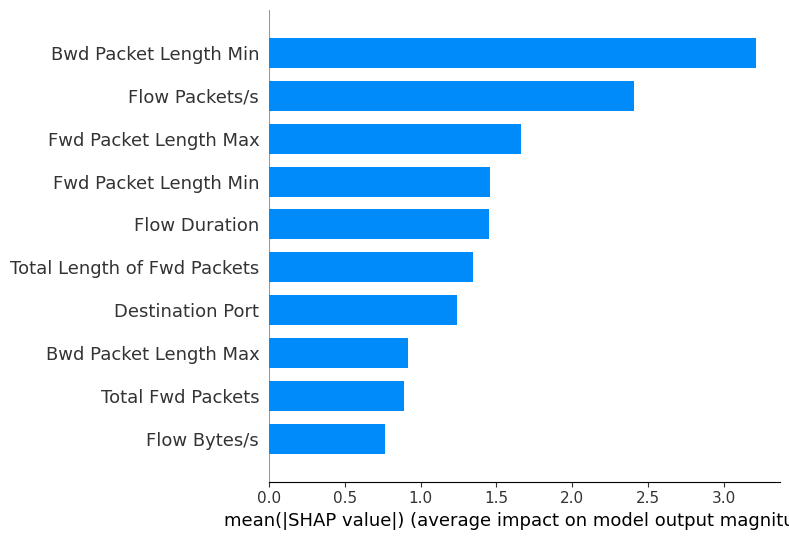

In [ ]:
import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
print("X_test_scaled shape:", X_test_scaled.shape)
print("y_test shape:", y_test.shape)
print("Unique classes in y_test:", np.unique(y_test))
feature_names = top_features.tolist()
print("Number of features in feature_names:", len(feature_names))
print("Feature names:", feature_names)
assert len(feature_names) == X_test_scaled.shape[1], f"Expected {X_test_scaled.shape[1]} features, got {len(feature_names)}"
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=feature_names)
background_idx = np.random.choice(X_test_scaled_df.shape[0], min(1000, X_test_scaled_df.shape[0]), replace=False)
background_data = X_test_scaled_df.iloc[background_idx, :].values
explainer = shap.TreeExplainer(model, data=background_data, feature_perturbation="interventional")
shap_values = explainer.shap_values(X_test_scaled_df.values)
print("SHAP values type:", type(shap_values))
if isinstance(shap_values, list):
    print("SHAP values list length (classes):", len(shap_values))
    print("Each SHAP array shape:", [arr.shape for arr in shap_values])
    assert len(shap_values) == 15, f"Expected 15 classes, got {len(shap_values)}"
    for arr in shap_values:
        assert arr.shape[1] == len(feature_names), f"SHAP array has {arr.shape[1]} features, expected {len(feature_names)}"
else:
    print("SHAP values shape:", shap_values.shape)
shap.summary_plot(shap_values, X_test_scaled_df, feature_names=feature_names, show=False, plot_type='bar')
plt.savefig('/content/shap_summary_multiclass.png')
print("Saved SHAP summary plot to /content/shap_summary_multiclass.png")
if isinstance(shap_values, list):
    shap.summary_plot(shap_values[0], X_test_scaled_df, feature_names=feature_names, show=False)
    plt.savefig('/content/shap_summary_class0.png')
    print("Saved SHAP class 0 plot to /content/shap_summary_class0.png")
subset_size = 100
X_subset = X_test_scaled_df.iloc[:subset_size, :].values
interaction_values = explainer.shap_interaction_values(X_subset)
print("Interaction values type:", type(interaction_values))
if isinstance(interaction_values, list):
    print("Interaction values list length (classes):", len(interaction_values))
    print("Each interaction array shape:", [arr.shape for arr in interaction_values])
else:
    print("Interaction values shape:", interaction_values.shape)
if isinstance(interaction_values, list):
    shap.summary_plot(interaction_values[0], X_subset, feature_names=feature_names, show=False)
    plt.savefig('/content/shap_interaction_class0.png')
    print("Saved interaction summary plot for class 0 to /content/shap_interaction_class0.png")

This cell imports numpy for numerical operations and sklearn's accuracy_score for model evaluation. It predicts on clean test data using a pre-trained model, computing baseline accuracy. SHAP values are used as a proxy for gradients to simulate an FGSM-style adversarial attack. For each epsilon value (0.01, 0.05, 0.1), it perturbs the test data by adding scaled perturbations based on the sign of mean absolute SHAP values (aggregated across classes). Predictions are made on the perturbed data, and accuracy under each attack strength is reported, assessing the model's robustness to adversarial perturbations.

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score
X_test_scaled_np = X_test_scaled.values
y_pred = model.predict(X_test_scaled_np)
y_pred_class = np.argmax(y_pred, axis=1)

print("Baseline Accuracy:", accuracy_score(y_test, y_pred_class))
shap_values = explainer.shap_values(X_test_scaled_np)
epsilons = [0.01, 0.05, 0.1]

for epsilon in epsilons:
    perturbed_X = X_test_scaled_np.copy()
    if isinstance(shap_values, list):
        mean_shap = np.mean([np.abs(sv) for sv in shap_values], axis=0)
    else:
        mean_shap = np.abs(shap_values)
    perturbation = np.sign(mean_shap)
    X_test_adv = perturbed_X + epsilon * perturbation
    y_pred_adv = model.predict(X_test_adv)
    y_pred_class_adv = np.argmax(y_pred_adv, axis=1)

    print(f"Accuracy under simulated FGSM attack (ε={epsilon}):", accuracy_score(y_test, y_pred_class_adv))


Baseline Accuracy: 0.9823008849557522


 98%|===================| 556/565 [00:31<00:00]       

Accuracy under simulated FGSM attack (ε=0.01): 0.8035398230088495
Accuracy under simulated FGSM attack (ε=0.05): 0.8035398230088495
Accuracy under simulated FGSM attack (ε=0.1): 0.8035398230088495


This cell trains a Logistic Regression classifier using SHAP values from a subset of training data to predict alerts based on feature importance. The classifier acts as a secondary decision layer, enhancing the system’s ability to flag potential intrusions for network security monitoring.

In [ ]:
from sklearn.linear_model import LogisticRegression
import numpy as np
def train_alert_classifier():
    shap_values_train = explainer.shap_values(X_train_scaled.iloc[:1000])
    if isinstance(shap_values_train, list):
        shap_input = np.abs(shap_values_train).mean(axis=0)  # shape: (1000, features)
    else:
        shap_input = np.abs(shap_values_train)

    clf = LogisticRegression(max_iter=500)
    clf.fit(shap_input, y_train.iloc[:1000])
    return clf
alert_classifier = train_alert_classifier()

100%|===================| 998/1000 [00:59<00:00]       

This cell defines a function to explain individual model predictions by generating SHAP force plots and listing the top contributing features for a test instance. It uses the alert classifier to estimate intrusion likelihood, producing detailed explanations saved as plots and returned as a dictionary for logging.

In [ ]:
import shap
import matplotlib.pyplot as plt
explain_config = {"top_k_features": 5}
def explain_alert(instance_idx, top_k=None):
    if top_k is None:
        top_k = explain_config["top_k_features"]
    alert_data = X_test_scaled.iloc[instance_idx:instance_idx+1]
    shap_values = explainer.shap_values(alert_data)
    y_pred = model.predict(alert_data)
    pred_class = np.argmax(y_pred, axis=1)[0]
    shap_values_single = shap_values[pred_class][0]
    top_local_indices = np.argsort(np.abs(shap_values_single))[::-1][:top_k]
    top_local_features = top_features[top_local_indices]
    top_local_shap_vals = shap_values_single[top_local_indices]
    print(f"\n[Instance {instance_idx}] Top {top_k} contributing features (Class {pred_class}):")
    for i, feature in enumerate(top_local_features):
        print(f"  {i+1}. {feature} (SHAP: {top_local_shap_vals[i]:.4f})")
    try:
      shap.force_plot(..., matplotlib=True, show=False)
      plt.savefig(f'/content/force_plot_instance_{instance_idx}.png', dpi=300)
      plt.close()
    except:
      print("⚠️ Could not render force plot.")

    plt.tight_layout()
    plt.savefig(f'/content/force_plot_instance_{instance_idx}.png', dpi=300, bbox_inches='tight')
    plt.close()
    shap_input = np.mean([np.abs(shap_val[0]) for shap_val in shap_values], axis=0)
    proba = alert_classifier.predict_proba([shap_input])[0]
    prediction = int(proba[1] > 0.5)
    confidence = proba[1]
    decision_msg = "⚠️ ML Alert: Intrusion likely" if prediction == 1 else "✅ ML Alert: Normal"
    return {
        "prediction": prediction,
        "confidence": confidence,
        "decision_message": decision_msg,
        "top_features": top_features[top_local_indices].tolist(),
        "shap_values": shap_values_single.tolist()
    }

This cell logs alerts for the first five test instances using a simplified explain_alert function, capturing prediction details, confidence, top features, and SHAP values. The logs are saved as a JSON file, enabling tracking of intrusion detection events for operational monitoring and analysis.

In [ ]:
import pandas as pd
import json
import numpy as np
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

alert_logs = []

def explain_alert(instance_idx, top_k=5):
    alert_data = X_test_scaled.iloc[instance_idx:instance_idx+1].values
    y_pred = model.predict(alert_data)
    pred_class = np.argmax(y_pred, axis=1)[0]
    shap_values = explainer.shap_values(alert_data)

    if isinstance(shap_values, list) and len(shap_values) > 1:
        shap_values_single = shap_values[pred_class][0]
    elif isinstance(shap_values, list):
        shap_values_single = shap_values[0][0]
    else:
        shap_values_single = shap_values[0]

    top_local_indices = np.argsort(np.abs(shap_values_single))[::-1][:top_k]
    return {
        "prediction": int(pred_class),
        "confidence": float(np.max(y_pred)),
        "top_features": X_test_scaled.columns[top_local_indices].tolist(),
        "shap_values": shap_values_single[top_local_indices].tolist(),
        "decision_message": f"Alert classified as class {pred_class} with {np.max(y_pred)*100:.2f}% confidence"
    }

def serialize(obj):
    if isinstance(obj, (np.integer, np.floating)):
        return obj.item()
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    raise TypeError

def log_alert(instance_idx):
    explanation = explain_alert(instance_idx)
    y_pred = model.predict(X_test_scaled.iloc[instance_idx:instance_idx+1].values)
    pred_class = np.argmax(y_pred, axis=1)[0]
    alert_logs.append({
        "alert_id": instance_idx,
        "timestamp": pd.Timestamp.now().isoformat(),
        "predicted_class": int(pred_class),
        "confidence": explanation["confidence"],
        "prediction": explanation["prediction"],
        "decision_message": explanation["decision_message"],
        "top_features": explanation["top_features"],
        "shap_values": explanation["shap_values"]
    })

# Log the first 5 alerts
for i in range(5):
    log_alert(i)

# Print the first alert
print(json.dumps(alert_logs[0], indent=2, default=serialize))

# Save all alerts to a file
with open('/content/alert_logs.json', 'w') as f:
    json.dump(alert_logs, f, indent=2, default=serialize)

print("Saved alert logs to /content/alert_logs.json")


{
  "alert_id": 0,
  "timestamp": "2025-05-10T10:57:48.866228",
  "predicted_class": 0,
  "confidence": 0.9999999804522434,
  "prediction": 0,
  "decision_message": "Alert classified as class 0 with 100.00% confidence",
  "top_features": [
    "Bwd Packet Length Min",
    "Fwd Packet Length Max",
    "Fwd Packet Length Min",
    "Destination Port",
    "Flow Duration"
  ],
  "shap_values": [
    3.1866813507175538,
    -2.1388601355855643,
    1.795026181730791,
    -1.5476764391968028,
    -1.0722739978885512
  ]
}
Saved alert logs to /content/alert_logs.json


This cell monitors model stability by detecting feature drift using both SHAP importance variance and Kolmogorov-Smirnov (KS) tests across random test data batches. It calculates SHAP variance and KS p-values, triggering a retraining alert if variance exceeds 0.1 or p-values indicate significant distribution shifts (p < 0.05), ensuring robust adaptation to evolving network traffic patterns.

In [ ]:
import numpy as np
from scipy.stats import ks_2samp
def detect_shap_feature_drift(explainer, X_data, num_batches=4, batch_size=100, drift_threshold=0.1, ks_threshold=0.05, random_seed=42):
    np.random.seed(random_seed)
    total_required = num_batches * batch_size
    if len(X_data) < total_required:
        raise ValueError(f"Not enough test samples ({len(X_data)}) for {num_batches} batches of size {batch_size}.")
    shuffled_indices = np.random.permutation(len(X_data))
    weekly_shap = []
    ks_p_values = []
    ref_idx = shuffled_indices[:batch_size]
    X_ref = X_data.iloc[ref_idx].values
    for i in range(num_batches):
        batch_idx = shuffled_indices[i * batch_size: (i + 1) * batch_size]
        X_batch = X_data.iloc[batch_idx]
        shap_values_batch = explainer.shap_values(X_batch)
        batch_mean = np.mean([np.abs(shap_val).mean(axis=0) for shap_val in shap_values_batch], axis=0)
        weekly_shap.append(batch_mean)
        p_vals = [ks_2samp(X_ref[:, j], X_batch.values[:, j]).pvalue for j in range(X_batch.shape[1])]
        ks_p_values.append(np.mean(p_vals))
    weekly_shap = np.array(weekly_shap)
    shap_variance = np.mean(np.var(weekly_shap, axis=0))
    mean_ks_p = np.mean(ks_p_values)
    print(f"\nSHAP Feature Drift Variance Across Batches: {shap_variance:.4f}")
    print(f"Mean KS Test p-value Across Batches: {mean_ks_p:.4f}")
    if shap_variance > drift_threshold or mean_ks_p < ks_threshold:
        print("⚠️ Trigger retraining: Drift detected (SHAP or KS).")
    else:
        print("✅ Model stable: No drift detected.")
detect_shap_feature_drift(explainer, X_test_scaled, num_batches=4, batch_size=100, drift_threshold=0.1)


SHAP Feature Drift Variance Across Batches: 0.0005
Mean KS Test p-value Across Batches: 0.8346
✅ Model stable: No drift detected.


This cell trains differentially private Logistic Regression models with varying privacy budgets (ε = 0.1, 0.5, 1.0, 5.0). It evaluates accuracy and macro F1 scores on the test set, balancing privacy and utility to ensure secure intrusion detection while maintaining model performance.

In [ ]:
from diffprivlib.models import LogisticRegression as DPLogReg
from numpy.linalg import norm
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
epsilons = [0.1, 0.5, 1.0, 5.0]
dp_results = []
dp_models = {}
dp_predictions = {}
for eps in epsilons:
  max_norm = np.max(np.linalg.norm(X_train_scaled, axis=1))
  dp_model = DPLogReg(epsilon=eps, data_norm=max_norm, max_iter=1000, random_state=42)
  dp_model.fit(X_train_scaled, y_train)
  dp_preds = dp_model.predict(X_test_scaled)
  acc = accuracy_score(y_test, dp_preds)
  f1 = f1_score(y_test, dp_preds, average='macro')
  dp_results.append((eps, acc, f1))
  dp_models[eps] = dp_model
  dp_predictions[eps] = dp_preds
  print(f"ε={eps}: Accuracy={acc:.4f}, Macro F1={f1:.4f}")

ε=0.1: Accuracy=0.0248, Macro F1=0.0074
ε=0.5: Accuracy=0.6142, Macro F1=0.0780
ε=1.0: Accuracy=0.7133, Macro F1=0.0849
ε=5.0: Accuracy=0.7912, Macro F1=0.1086


This cell generates five visualizations to analyze the differentially private model’s performance: a privacy-utility tradeoff plot, an accuracy bar plot, a confusion matrix heatmap, precision-recall curves, and a summary table. These high-quality PNGs provide insights into the trade-offs between privacy and model effectiveness.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, precision_recall_curve
import matplotlib.table as tbl
import os
plt.rcParams.update({
    'font.size': 14,
    'axes.labelsize': 16,
    'axes.titlesize': 18,
    'legend.fontsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'figure.figsize': (12, 8)
})
output_dir = '/content/dp_visualizations'
os.makedirs(output_dir, exist_ok=True)
fig, ax = plt.subplots(figsize=(12, 8))
epsilons, accuracies, f1_scores = zip(*dp_results)
ax.plot(epsilons, accuracies, marker='o', linestyle='-', linewidth=2, markersize=10, label='Accuracy', color='navy')
ax.plot(epsilons, f1_scores, marker='s', linestyle='--', linewidth=2, markersize=10, label='Macro F1', color='darkorange')
ax.set_xlabel('Privacy Budget (ε)', fontsize=16)
ax.set_ylabel('Metric Value', fontsize=16)
ax.set_title('Differential Privacy: Accuracy and F1 Score vs. Privacy Budget', fontsize=18, pad=15)
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend(fontsize=12, loc='best')
ax.set_xscale('log')
ax.set_xticks(epsilons)
ax.set_xticklabels([f'{eps:.1f}' for eps in epsilons])
for i, (eps, acc, f1) in enumerate(dp_results):
    ax.annotate(f'{acc:.3f}', (eps, acc), textcoords="offset points", xytext=(0,10), ha='center', fontsize=10, color='navy')
    ax.annotate(f'{f1:.3f}', (eps, f1), textcoords="offset points", xytext=(0,-15), ha='center', fontsize=10, color='darkorange')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'dp_tradeoff_enhanced.png'), dpi=300, format='png', bbox_inches='tight')
plt.close()
print(f"Saved Visualization 1 to {output_dir}/dp_tradeoff_enhanced.png")
fig, ax = plt.subplots(figsize=(12, 8))
bars = ax.bar(epsilons, accuracies, color='teal', edgecolor='black', alpha=0.8)
ax.set_xlabel('Privacy Budget (ε)', fontsize=16)
ax.set_ylabel('Accuracy', fontsize=16)
ax.set_title('Accuracy Across Different Privacy Budgets', fontsize=18, pad=15)
ax.grid(True, axis='y', linestyle='--', alpha=0.7)
ax.set_xticks(epsilons)
ax.set_xticklabels([f'{eps:.1f}' for eps in epsilons])
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.3f}', ha='center', va='bottom', fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'dp_accuracy_bar.png'), dpi=300, format='png', bbox_inches='tight')
plt.close()
print(f"Saved Visualization 2 to {output_dir}/dp_accuracy_bar.png")
best_eps = max(dp_results, key=lambda x: x[1])[0]
cm = confusion_matrix(y_test, dp_predictions[best_eps])
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar_kws={'label': 'Count'})
ax.set_xlabel('Predicted Label', fontsize=16)
ax.set_ylabel('True Label', fontsize=16)
ax.set_title(f'Confusion Matrix for DP Model (ε={best_eps})', fontsize=18, pad=15)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'dp_confusion_matrix.png'), dpi=300, format='png', bbox_inches='tight')
plt.close()
print(f"Saved Visualization 3 to {output_dir}/dp_confusion_matrix.png")
fig, ax = plt.subplots(figsize=(12, 8))
n_classes = dp_models[best_eps].predict_proba(X_test_scaled).shape[1]
for class_idx in range(n_classes):
    y_true_bin = (y_test == class_idx).astype(int)
    if best_eps in dp_models and hasattr(dp_models[best_eps], 'predict_proba'):
        y_score = dp_models[best_eps].predict_proba(X_test_scaled)[:, class_idx]
        precision, recall, _ = precision_recall_curve(y_true_bin, y_score)
        ax.plot(recall, precision, label=f'Class {class_idx}', linewidth=2)
ax.set_xlabel('Recall', fontsize=16)
ax.set_ylabel('Precision', fontsize=16)
ax.set_title(f'Precision-Recall Curves for DP Model (ε={best_eps})', fontsize=18, pad=15)
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend(fontsize=10, loc='best', ncol=2)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'dp_precision_recall.png'), dpi=300, format='png', bbox_inches='tight')
plt.close()
print(f"Saved Visualization 4 to {output_dir}/dp_precision_recall.png")
fig, ax = plt.subplots(figsize=(12, 8))
ax.axis('off')
table_data = [[f'{eps:.1f}', f'{acc:.3f}', f'{f1:.3f}'] for eps, acc, f1 in dp_results]
table = tbl.table(
    ax,
    cellText=table_data,
    colLabels=['Privacy Budget (ε)', 'Accuracy', 'Macro F1'],
    loc='center',
    cellLoc='center',
    colColours=['#f0f0f0']*3,
    bbox=[0, 0, 1, 1]
)
table.auto_set_font_size(False)
table.set_fontsize(12)
plt.title('Differential Privacy Performance Metrics', fontsize=18, pad=15)
plt.savefig(os.path.join(output_dir, 'dp_metrics_table.png'), dpi=300, format='png', bbox_inches='tight')
plt.close()
print(f"Saved Visualization 5 to {output_dir}/dp_metrics_table.png")

Saved Visualization 1 to /content/dp_visualizations/dp_tradeoff_enhanced.png
Saved Visualization 2 to /content/dp_visualizations/dp_accuracy_bar.png
Saved Visualization 3 to /content/dp_visualizations/dp_confusion_matrix.png
Saved Visualization 4 to /content/dp_visualizations/dp_precision_recall.png
Saved Visualization 5 to /content/dp_visualizations/dp_metrics_table.png


This cell saves the trained LightGBM model to a file and lists all generated outputs, including plots, logs, and the model file. It provides a summary of saved artifacts, ensuring easy access to results for further analysis or deployment in the intrusion detection system.

In [ ]:
import os
model.save_model('/content/lightgbm_model.txt')
print("Saved model to /content/lightgbm_model.txt")
print("\nSaved files:")
for file in os.listdir('/content'):
    if file.endswith('.png') or file.endswith('.json') or file.endswith('.txt'):
        print(f"- {file}")
for file in os.listdir('/content/dp_visualizations'):
    print(f"- dp_visualizations/{file}")

Saved model to /content/lightgbm_model.txt

Saved files:
- lightgbm_model.txt
- shap_summary_multiclass.png
- alert_logs.json
- dp_visualizations/dp_accuracy_bar.png
- dp_visualizations/dp_confusion_matrix.png
- dp_visualizations/dp_tradeoff_enhanced.png
- dp_visualizations/dp_precision_recall.png
- dp_visualizations/dp_metrics_table.png


This cell records the end time of the notebook’s execution using the time module and stores it with Colab’s %store command. This sets up the calculation of total execution time, critical for evaluating the pipeline’s efficiency for real-time network security applications.

In [ ]:
end_time = time.time()
%store end_time

Stored 'end_time' (float)


This cell retrieves the start and end times stored earlier, calculates the total execution time, and prints it. This metric helps assess the computational efficiency of the entire pipeline, ensuring it meets the performance requirements for real-time intrusion detection.

In [ ]:
%store -r start_time
%store -r end_time
duration = end_time - start_time
print(f"Total execution time: {duration:.2f} seconds")

Total execution time: 685.28 seconds
